In [61]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

%matplotlib inline

sns.set()
sns.set_context("poster", font_scale = 1, rc={"grid.linewidth": 5})


# its possible to look at Confirmed,Recovered or Deaths simply by changing the filename below
# assign either of ['Confirmed','Deaths','Recovered'] to param below:

param = 'Confirmed'

df_confirmed = pd.read_csv(
    '../../corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-' + param + '.csv',
                sep=',',encoding='ISO8859-1')
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,50,50,50,53,59,70,75,82,114,147
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,461,502,511,581,639,639,701,773,839,825
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,138,150,150,160,178,178,200,212,226,243
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,93,99,117,129,149,149,197,238,428,566


In [62]:
countries = df_confirmed.groupby('Country/Region')

### SELECT Country
s = countries.get_group('Sweden').iloc[:,4:].sum()
###

s.index = pd.to_datetime(s.index)
mask = s > 1
s = pd.DataFrame(s[mask],columns=['confirmed'])
s['log'] = np.log10(s['confirmed'])
s['day'] = np.arange(1,len(s) + 1).astype(int)
s['factor'] = s['confirmed'] / s['confirmed'].shift()
s

,confirmed,log,day,factor
2020-02-26,2,0.301030,1,NaN
2020-02-27,7,0.845098,2,3.500000
2020-02-28,7,0.845098,3,1.000000
2020-02-29,12,1.079181,4,1.714286
2020-03-01,14,1.146128,5,1.166667
2020-03-02,15,1.176091,6,1.071429
2020-03-03,21,1.322219,7,1.400000
2020-03-04,35,1.544068,8,1.666667
2020-03-05,94,1.973128,9,2.685714
2020-03-06,101,2.004321,10,1.074468


In [63]:
# PATCH missing days
'''
yesterday = pd.to_datetime('2020-03-13')
today = pd.to_datetime('2020-03-14')

y_data = [687,np.log10(687),17]
temp = pd.DataFrame({yesterday : y_data}).T
temp.columns=['confirmed','log','day']
s = s.append(temp)

y_data = [814,np.log10(814),18]
temp = pd.DataFrame({today : y_data}).T
temp.columns=['confirmed','log','day']
s = s.append(temp)
s['factor'] = (s['confirmed'] / s['confirmed'].shift())

s
'''

"\nyesterday = pd.to_datetime('2020-03-13')\ntoday = pd.to_datetime('2020-03-14')\n\ny_data = [687,np.log10(687),17]\ntemp = pd.DataFrame({yesterday : y_data}).T\ntemp.columns=['confirmed','log','day']\ns = s.append(temp)\n\ny_data = [814,np.log10(814),18]\ntemp = pd.DataFrame({today : y_data}).T\ntemp.columns=['confirmed','log','day']\ns = s.append(temp)\ns['factor'] = (s['confirmed'] / s['confirmed'].shift())\n\ns\n"

In [64]:
s.describe()

,confirmed,log,day,factor
count,20.000000,20.000000,20.00000,19.000000
mean,313.700000,1.955857,10.50000,1.477684
std,381.402274,0.859269,5.91608,0.621079
min,2.000000,0.301030,1.00000,1.000000
25%,14.750000,1.168600,5.75000,1.122962
50%,131.000000,2.105574,10.50000,1.260870
75%,524.750000,2.718584,15.25000,1.512756
max,1103.000000,3.042576,20.00000,3.500000


Text(0.5, 1.0, 'Nr Infected [Log-10]')

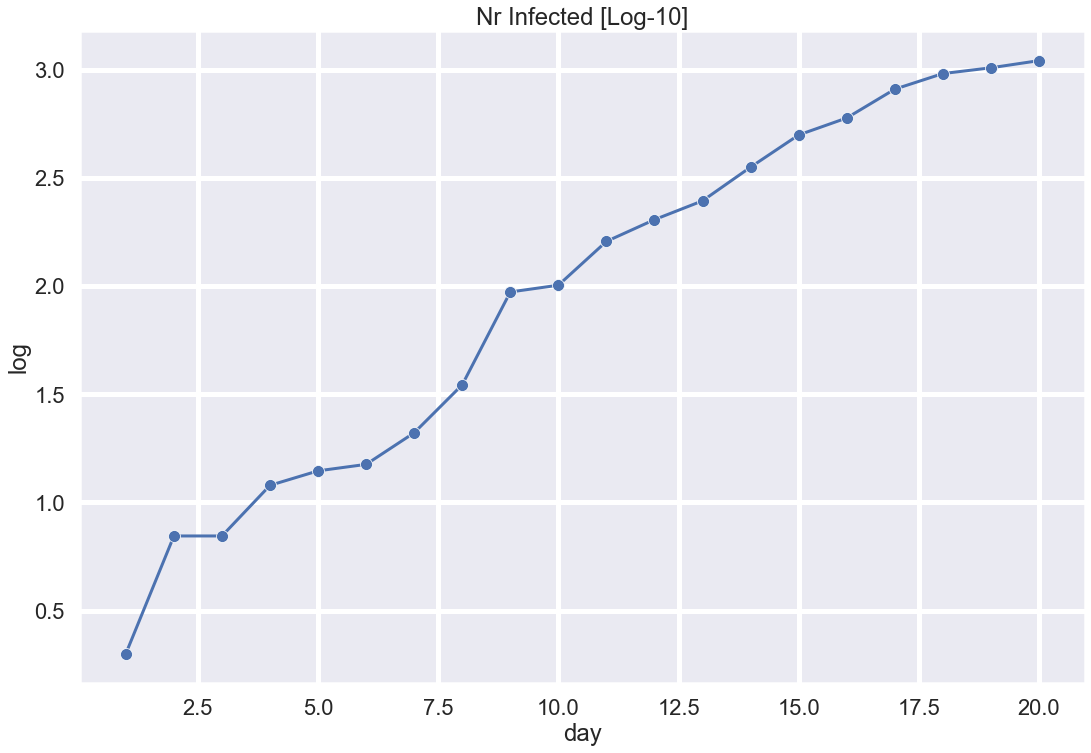

In [65]:
plt.figure(figsize=(18,12))
sns.lineplot(x=s['day'],y=s['log'],data=s,markers=True,marker='o').set_title('Nr Infected [Log-10]')

In [66]:
s['std_x'] = (s['day'] - s['day'].mean()) / s['day'].std()
s['std_y'] = (s['log'] - s['log'].mean()) / s['log'].std()
s['factor_log'] = np.log10(s['factor'])
s

,confirmed,log,day,factor,std_x,std_y,factor_log
2020-02-26,2,0.301030,1,NaN,-1.605793,-1.925854,NaN
2020-02-27,7,0.845098,2,3.500000,-1.436762,-1.292679,0.544068
2020-02-28,7,0.845098,3,1.000000,-1.267731,-1.292679,0.000000
2020-02-29,12,1.079181,4,1.714286,-1.098701,-1.020258,0.234083
2020-03-01,14,1.146128,5,1.166667,-0.929670,-0.942346,0.066947
2020-03-02,15,1.176091,6,1.071429,-0.760639,-0.907476,0.029963
2020-03-03,21,1.322219,7,1.400000,-0.591608,-0.737415,0.146128
2020-03-04,35,1.544068,8,1.666667,-0.422577,-0.479232,0.221849
2020-03-05,94,1.973128,9,2.685714,-0.253546,0.020100,0.429060
2020-03-06,101,2.004321,10,1.074468,-0.084515,0.056402,0.031194


In [67]:
s.describe()

,confirmed,log,day,factor,std_x,std_y,factor_log
count,20.000000,20.000000,20.00000,19.000000,2.000000e+01,2.000000e+01,19.000000
mean,313.700000,1.955857,10.50000,1.477684,-1.110223e-17,1.221245e-16,0.144292
std,381.402274,0.859269,5.91608,0.621079,1.000000e+00,1.000000e+00,0.139889
min,2.000000,0.301030,1.00000,1.000000,-1.605793e+00,-1.925854e+00,0.000000
25%,14.750000,1.168600,5.75000,1.122962,-8.028965e-01,-9.161932e-01,0.050036
50%,131.000000,2.105574,10.50000,1.260870,0.000000e+00,1.742374e-01,0.100670
75%,524.750000,2.718584,15.25000,1.512756,8.028965e-01,8.876469e-01,0.179141
max,1103.000000,3.042576,20.00000,3.500000,1.605793e+00,1.264702e+00,0.544068


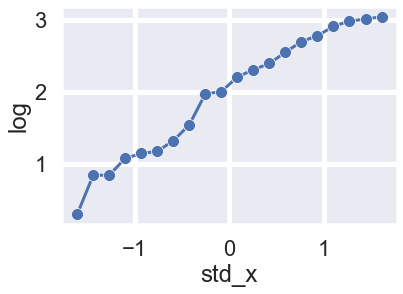

In [68]:
sns.lineplot(x='std_x',y='log',data=s,marker='o')

In [69]:
alpha_mu = 1.8
alpha_sigma = 0.5
beta_mu = 0.8
beta_sigma = 0.5
sigma_sigma = 0.000001 #0.0001

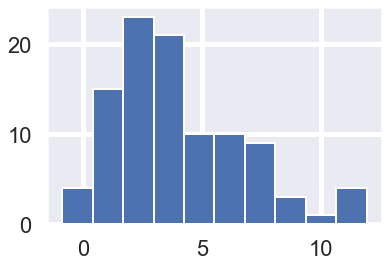

In [70]:
#simulate lines
nr_samples = 10000
nr_lines = 100

alpha = pm.rnormal(alpha_mu, 1 / alpha_sigma ** 2, nr_samples)
beta = pm.rnormal(beta_mu, 1 / beta_sigma ** 2, nr_samples)

#X = np.linspace(min(s['std_x']), max(s['std_x']),nr_lines)
# extend X over the data period
X = np.linspace(min(s['std_x']),max(s['std_x']) * 4, nr_lines)
                
alphas = np.random.choice(alpha,replace=True,size=nr_lines)
betas = np.random.choice(beta,replace=True,size=nr_lines)

def linreq_mu(x,alpha,beta):
    return x*beta+alpha

gen_factors = linreq_mu(X,alphas,betas)
_ = plt.hist(gen_factors)



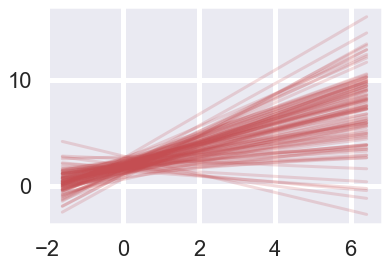

In [71]:
lines = np.array([X[i] * betas + alphas for i in range(len(X))])
_= plt.plot(X,lines,color='r',alpha=0.2)

In [72]:
alpha = pm.Normal('alpha',mu=alpha_mu,tau = 1 / alpha_sigma ** 2)
beta = pm.Normal('beta',mu=beta_mu,tau = 1 / beta_sigma ** 2)

# by changing sigma from uniform to lognormal, the y-range of sample plot below
# shrunk a lot

sigma = pm.Lognormal('sigma',mu=0,tau = 0.1 / sigma_sigma ** 2)

@pm.deterministic()
def linreq_mu(x=s['std_x'],alpha=alpha,beta=beta):
    return x*beta+alpha

likelihood  = pm.Normal('likelihood',mu=linreq_mu,tau= 1 / sigma ** 2,
                       observed=True,value=s['log'])

model = pm.Model([alpha,beta,sigma,linreq_mu,likelihood])
map_ = pm.MAP(model)
map_.fit()

mcmc = pm.MCMC(model)

mcmc.sample(10000,5000,2)

alpha_samples = mcmc.trace('alpha')[:]
beta_samples = mcmc.trace('beta')[:]
sigma_samples = mcmc.trace('sigma')[:]
linreq_mu_samples = mcmc.trace('sigma')[:]

result = pd.DataFrame({'alpha_post': alpha_samples,
                     'beta_post' : beta_samples,
                     'sigma_post' : sigma_samples,
                     'linreq_mu_post' : linreq_mu_samples})

result.describe()



 [-----------------100%-----------------] 10000 of 10000 complete in 12.9 sec

,alpha_post,beta_post,sigma_post,linreq_mu_post
count,2500.000000,2500.000000,2500.000000,2500.000000
mean,1.917942,0.842712,1.000000,1.000000
std,0.201497,0.199629,0.000003,0.000003
min,1.095437,0.005462,0.999990,0.999990
25%,1.789960,0.706549,0.999998,0.999998
50%,1.916979,0.839334,1.000000,1.000000
75%,2.051204,0.966957,1.000002,1.000002
max,2.708815,1.520102,1.000009,1.000009


In [73]:
alphas = np.random.choice(result['alpha_post'],replace=True,size=nr_lines)
betas = np.random.choice(result['beta_post'],replace=True,size=nr_lines)
sigmas = np.random.choice(result['sigma_post'],replace=True,size=nr_lines)

lines = np.array([X[i] * betas + alphas for i in range(len(X))])
print (lines.min(),lines.max())

-0.328661945922643 10.225825207086606


In [74]:
slope,intercept,_,_,_ = sps.linregress(s['std_x'],s['log'])

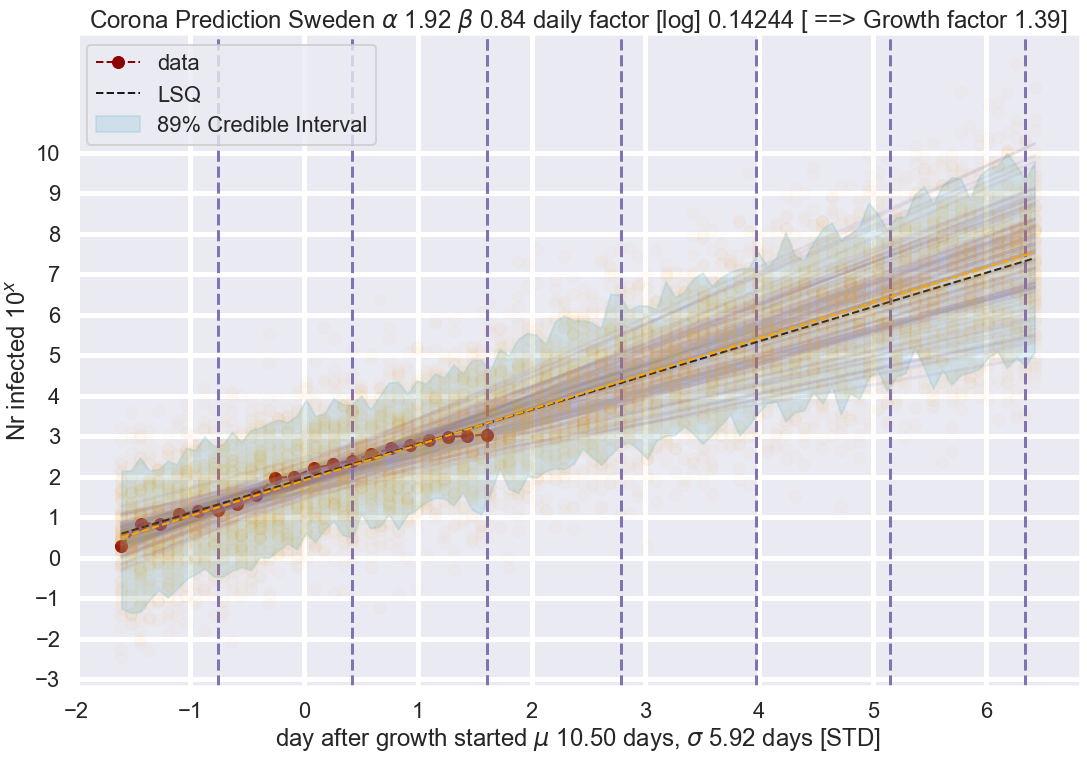

In [75]:
# lin/log plot - x standardized

plt.figure(figsize=(18,12))

daily_increase_log = result['beta_post'].mean() / s['day'].std()
daily_increase_lin = np.power(10,daily_increase_log)

title = r'Corona Prediction Sweden $\alpha$ {:.2f} $\beta$ {:.2f} '\
    'daily factor [log] {:.5f} [ ==> Growth factor {:.2f}]'.format(result['alpha_post'].mean(),
                                                            result['beta_post'].mean(),
                                                            daily_increase_log,
                                                            daily_increase_lin)
plt.title(title)

day_mean = s['day'].mean()
day_std = s['day'].std()
y_mean = s['log'].mean()
y_std = s['log'].std()

plt.xlabel(r'day after growth started $\mu$ {:.2f} days, $\sigma$ {:.2f} days [STD]'.format(day_mean,day_std))
plt.ylabel(r'Nr infected 10$^{x}$')

plt.yticks(np.arange( -3,11 ,1))

#plt.axvline(max(s['std_x']),ls='dashed',color='k',label='last real data point')

week_in_std = 7 * 1 / s['day'].std()

week_bars = np.arange(max(s['std_x']),max(X),week_in_std)
for w in week_bars:
    plt.axvline(w,ls='dashed',color='m')
    
week_bars = np.arange(max(s['std_x']),min(X),-week_in_std)
for w in week_bars:
    plt.axvline(w,ls='dashed',color='m')
    

plt.plot(s['std_x'],s['log'],'o--',color='darkred',label='data',lw=2,ms=12)
plt.plot(X,lines,color='m',alpha=0.1)

plt.plot(X,[X[i] * slope + intercept for i in range(len(X))], 
         color='k',ls = 'dashed', label='LSQ',lw=2,alpha=1 )

plt.plot(X,[X[i] * betas.mean() + alphas.mean() for i in range(len(X))],
        color='orange',ls='dashed',lw=2)

# the rnormal returns a 2 x 2 matrix, with each row containing a complete line's yvals. 
samples = np.array(
    [pm.rnormal(X[i] * betas + alphas,sigmas) for i in range(len(X))])

low,high = np.percentile(samples,[5.5,94.5],axis=1)
last_low,last_high = low[-1],high[-1]


plt.fill_between(np.linspace(min(X),max(X),high.size),
                low,high,color='c',alpha=0.2,label='89% Credible Interval')

for i in range(len(X)):
    plt.plot(X,samples[:,i],'o',color='orange',alpha=0.02)
plt.legend(loc='upper left')
plt.savefig('corona_prediction_lin_log.jpg',format='jpg')